In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_feynmannd
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import dataset_miscnd
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 200
MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 20
GENERATIONS      = 25
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 20000
LIB_MAXDEPTH  = 3 #5
LIB_MAXLENGTH = 10 #15

BACKPROP_TRIALS = 2

RANDSTATE = 124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc3d.Resistance3()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.RocketFuelFlow()
#S = dataset_physics.AircraftLift()
#S = dataset_misc2d.Pagie1()
#S = dataset_miscnd.WavePower()
#S = dataset_feynmannd.FeynmanIICh6Eq15a()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
import profiling
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

const_prob = 0.0 if S.knowledge.has_symmvars() else 0.5
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=const_prob)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
data_evaluator = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, data_evaluator, know_pressure=1.0)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
profiling.enable()
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)
#corrector.backprop_trials = BACKPROP_TRIALS
profiling.disable()

settings = gp.GPSettings(
      POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
      creator=solutionCreator,
      evaluator=evaluator,
      selector=selector,
      crossover=crossover,
      mutator=multiMutator,
      corrector=corrector,
      mutrate=MUTATION_RATE,
      elitism=ELITISM,
      knowledge=S.knowledge)
#symb_regressor = gp.GP(settings)
symb_regressor = gp.MOGP(settings)

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

#profiling.print_stats()

test_data_evaluator = gp_evaluator.R2Evaluator(S_test)
best_stree.clear_output()
print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
print(f"Test R2: {test_data_evaluator.evaluate(best_stree).value}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/24 [00:00<?, ?it/s]


--- Best syntax tree ---
(x1 / ((x1 + x0) / x0))
fea: 1.0
R²: 1.0
Max depth: 3
Length: 7
Test R2: 1.0


In [5]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
print(S.evaluate_extra(best_stree))
print(know_evaluator.evaluate(best_stree))

{'mse': 1.9102678364638164e-31, 'rmse': 4.3706610901141907e-16, 'r2': 1.0}
(301, 0)


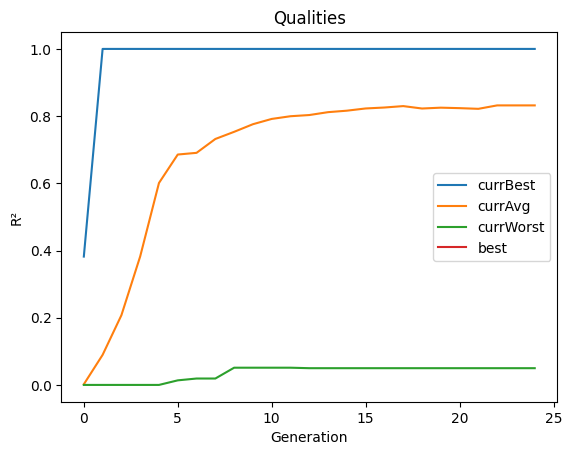

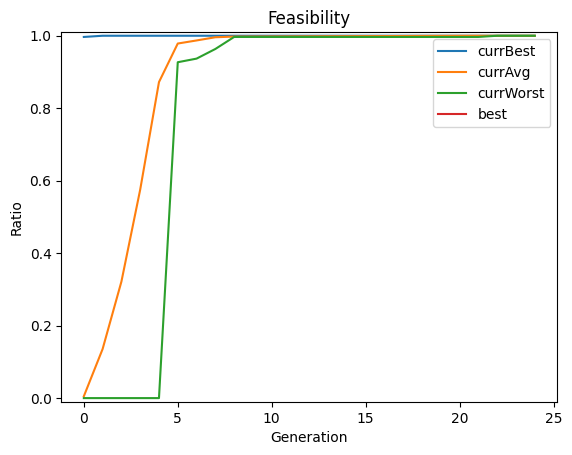

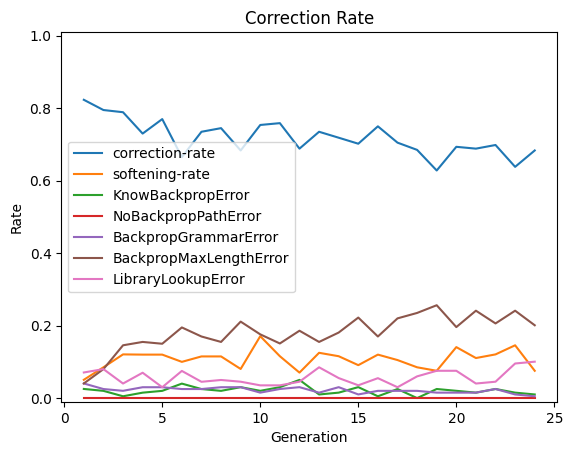

In [6]:
symb_regressor.stats.plot()

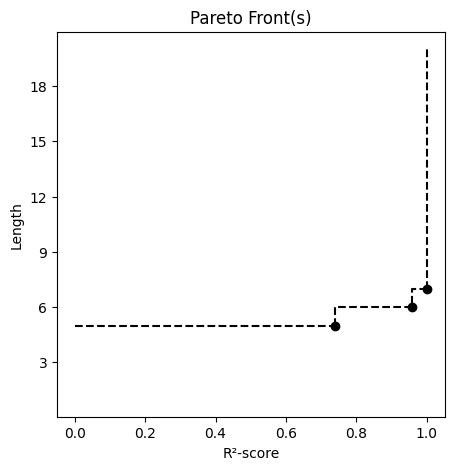

Feasibility Ratio: 1.0
Extent of Convergence: 0.7735412217768524


,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(x1 / ((x1 + x0) / x0)),0,0.650000,1.000000,7,"(/, +)",1,inf
1,1,(0.20 * (x1 + x0)),0,0.554665,0.739554,5,(+),1,inf
2,2,(0.50 * sqrt((x1 * x0))),0,0.670411,0.957729,6,"(*, sqrt)",1,2.000000
3,0,(1.00 / ((x0 + x1) / (x1 * x0))),1,0.550000,1.000000,9,"(/, *, +)",1,inf
4,1,sqrt((0.21 * (x0 * x1))),1,0.670338,0.957625,6,"(*, sqrt)",1,inf
5,0,(square(x1) / (x1 + square((x1 / sqrt(x0))))),2,0.500000,1.000000,10,"(/, sqrt, square, +)",1,inf
6,1,sqrt((0.20 * (x0 * x1))),2,0.662386,0.946266,6,"(*, sqrt)",1,inf
7,2,(0.47 * (x0 * (sqrt(x1) / sqrt(x0)))),2,0.530848,0.965178,9,"(*, sqrt, /)",1,2.000000
8,0,((x1 / (((x1 + x0) - x1) + x1)) * x0),3,0.450000,1.000000,11,"(*, +, /)",2,inf
9,1,(0.43 * sqrt((x1 * x0))),3,0.654129,0.934470,6,"(*, sqrt)",2,inf


In [7]:
pd_data = []
front_tracker, fea_ratio = symb_regressor.fea_front_tracker.get_head(0)

for frontidx in range(len(front_tracker.front)):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

data_lu = (0.0,1.0)
length_lu = (1,MAX_STREE_LENGTH)

front_tracker.plot(data_lu, length_lu, [0])
print(f"Feasibility Ratio: {fea_ratio}")
print(f"Extent of Convergence: {front_tracker.compute_extend_of_convergence(data_lu, length_lu)}")
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)